In [1]:
import torch.utils.data as utils

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

from torch.optim import lr_scheduler

from sklearn.metrics import balanced_accuracy_score

from torch.utils.data import Dataset, DataLoader

import pandas as pd
import pickle

import numpy as np

from barbar import Bar

import time

%matplotlib inline 
import matplotlib.pyplot as plt

In [3]:
torch.manual_seed(27)

In [4]:
def plot_acc(history):
    fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
    axarr[0].plot(range(0, len(history)), history['acc'], label='train score')
    axarr[0].plot(range(0, len(history)), history['val_acc'], label='test score')
    axarr[0].set_xlabel('Number of Epochs', fontsize=18)
    axarr[0].set_ylabel('Accuracy', fontsize=18)
    axarr[0].set_ylim([0,1])
    axarr[1].plot(range(0, len(history)), history['acc'], label='train score')
    axarr[1].plot(range(0, len(history)), history['val_acc'], label='test score')
    axarr[1].set_xlabel('Number of Epochs', fontsize=18)
    axarr[1].set_ylabel('Accuracy', fontsize=18)
    axarr[1].set_ylim([0.7,1])
    plt.legend()
    plt.show()

In [5]:
DATAPATH = 'data/features/'
MODELPATH = 'output/models/'

### STEP 2: LOADING DATASET 

In [6]:
class CattleSoundDataset(Dataset):
    """ FreeSound dataset."""

    # Initialize your data, download, etc.
    def __init__(self, X, y):
        
        self.len = X.shape[0]
        self.x_data = torch.from_numpy(X)
        self.y_data = torch.from_numpy(y)

    def __getitem__(self, index):
        return (self.x_data[index], self.y_data[index])

    def __len__(self):
        return self.len

In [7]:
X_train = np.load('data/train_test/X_mel_train.npy')

In [8]:
X_test = np.load('data/train_test/X_mel_test.npy')

In [9]:
y_train = np.load('data/train_test/y_mel_train.npy')

In [10]:
y_test = np.load('data/train_test/y_mel_test.npy')

In [40]:
file_names = pd.read_csv('data/raw/test_files.csv')

In [11]:
print('X_train:', X_train.shape)

print('X_test:', X_test.shape)

print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (1225, 35, 161)
X_test: (307, 35, 161)
y_train: (1225,)
y_test: (307,)


In [12]:
train_dataset = CattleSoundDataset(X_train, y_train)

In [13]:
test_dataset = CattleSoundDataset(X_test, y_test)

### STEP 2: MAKING DATASET ITERABLE

In [14]:
batch_size = 32
n_iters = 1000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [15]:
num_epochs

26

In [16]:
transformations = transforms.Compose([transforms.ToTensor()])

In [17]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size= batch_size, 
                                           shuffle=True)

In [18]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [19]:
dataset_sizes = {'train':len(train_loader.dataset),'valid':len(test_loader.dataset)}

In [20]:
dataloaders = {'train':train_loader,'valid':test_loader}

### STEP 3: CREATE MODEL CLASS

In [21]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=(1,1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=(1,1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self.max_pool = nn.MaxPool2d(2)
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.max_pool(x)
        return x

In [22]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv = nn.Sequential(
            ConvBlock(in_channels=1, out_channels=32),
            ConvBlock(in_channels=32, out_channels=64),
            ConvBlock(in_channels=64, out_channels=128),
        )
        
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(10240, 1024),
            nn.PReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.1),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        #x = torch.mean(x, dim=3)
        #x, _ = torch.max(x, dim=2)
        out = self.fc(out)
        return out

### STEP 4: INSTANTIATE MODEL CLASS

In [23]:
model = CNNModel(num_classes=3)

In [24]:
#######################
#  USE GPU FOR MODEL  #
#######################

if torch.cuda.is_available():
    model.cuda()

### STEP 5: INSTANTIATE LOSS CLASS

In [25]:
criterion = nn.CrossEntropyLoss().cuda()

### STEP 6: INSTANTIATE OPTIMIZER CLASS

In [26]:
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### STEP 7: TRAIN THE MODEL

In [27]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs, graph=False):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    history = pd.DataFrame()
    train_acc = []
    val_acc = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Calculate Accuracy         
            y_pred = []
            y_true = []

            
            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if torch.cuda.is_available():
                    inputs = Variable(inputs.unsqueeze(1).cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs.unsqueeze(1)), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                outputs = model(inputs.to(dtype=torch.float))
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)
                
                if torch.cuda.is_available():
                    y_pred += preds.cpu().numpy().tolist()
                    y_true += labels.cpu().numpy().tolist()
                    
                else:
                    y_pred += preds.numpy()
                    y_true += labels.numpy()
        
                

            epoch_loss = running_loss / dataset_sizes[phase]
            #epoch_acc = running_corrects / dataset_sizes[phase]
            epoch_acc = balanced_accuracy_score(y_true, y_pred)
            
            if phase == 'train':
                train_acc.append(epoch_acc)
            else:
                val_acc.append(epoch_acc)
            
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    history['val_acc'] = val_acc
    history['acc'] = train_acc
    
    if graph:
        print()
        print('==========' * 10)
        plot_acc(history)
        
        
    
    
    return model

Epoch 0/25
----------
train Loss: 0.0294 Acc: 0.6350
valid Loss: 0.0215 Acc: 0.6607

Epoch 1/25
----------
train Loss: 0.0174 Acc: 0.7590
valid Loss: 0.0187 Acc: 0.7488

Epoch 2/25
----------
train Loss: 0.0139 Acc: 0.8152
valid Loss: 0.0174 Acc: 0.8277

Epoch 3/25
----------
train Loss: 0.0130 Acc: 0.8017
valid Loss: 0.0172 Acc: 0.7467

Epoch 4/25
----------
train Loss: 0.0112 Acc: 0.8485
valid Loss: 0.0234 Acc: 0.7304

Epoch 5/25
----------
train Loss: 0.0092 Acc: 0.8615
valid Loss: 0.0177 Acc: 0.7322

Epoch 6/25
----------
train Loss: 0.0066 Acc: 0.9027
valid Loss: 0.0184 Acc: 0.7771

Epoch 7/25
----------
train Loss: 0.0046 Acc: 0.9443
valid Loss: 0.0163 Acc: 0.8123

Epoch 8/25
----------
train Loss: 0.0036 Acc: 0.9548
valid Loss: 0.0170 Acc: 0.8016

Epoch 9/25
----------
train Loss: 0.0028 Acc: 0.9623
valid Loss: 0.0171 Acc: 0.8163

Epoch 10/25
----------
train Loss: 0.0023 Acc: 0.9770
valid Loss: 0.0184 Acc: 0.7868

Epoch 11/25
----------
train Loss: 0.0018 Acc: 0.9857
valid Loss

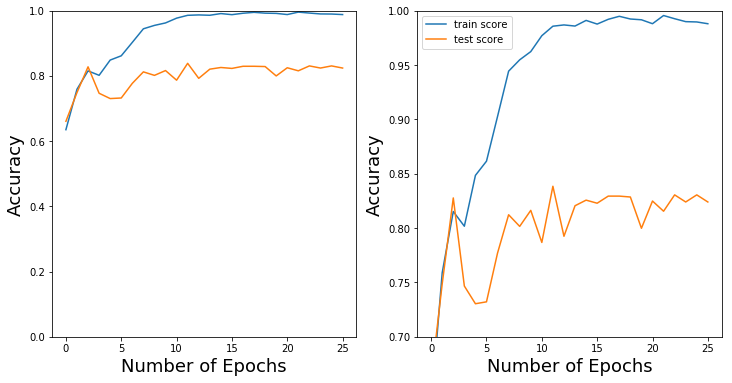

In [28]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=num_epochs, graph=True)



### STEP 8: SAVING THE MODEL

In [29]:
state = {
    'epoch': num_epochs,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
}
torch.save(state, MODELPATH+'cnn_pretrained.model')

### STEP 9: LOAD SUBMIT DATASET

In [30]:
DATAPATH = 'data/features/submission_mel_005.npy'
BATCHSIZE = 32

In [31]:
submission = np.load(DATAPATH)

In [32]:
labels = np.zeros(submission.shape[0])

In [33]:
print('submission:', submission.shape)

submission: (1551, 35, 161)


In [34]:
submission_dataset = CattleSoundDataset(submission, labels)

In [35]:
transformations = transforms.Compose([transforms.ToTensor()])

In [36]:
submission_loader = torch.utils.data.DataLoader(dataset=submission_dataset, 
                                           batch_size= BATCHSIZE, 
                                           shuffle=True)

### STEP 10: SCORING

In [37]:
submit = []
for images, labels in submission_loader:
    #######################
    #  USE GPU FOR MODEL  #
    #######################
    if torch.cuda.is_available():
        images = Variable(images.unsqueeze(1).cuda())
    else:
        images = Variable(images.unsqueeze(1))

    # Forward pass only to get logits/output
    outputs = model(images.to(dtype=torch.float))
    if len(submit):
        submit = np.concatenate((submit, outputs.cpu().detach().numpy()), axis=0) 
    else:
        submit = outputs.cpu().detach().numpy()
    

In [38]:
submit = np.argmax(submit,axis=1)

### STEP 11: SUBMIT

In [41]:
ds = pd.DataFrame({'file' : file_names.filename, 'prediction' : submit})
ds.to_csv("output/submits/submit_011.csv", index=False, header=None)

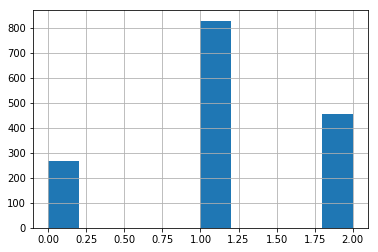

In [42]:
ds['prediction'].hist()
pass